## 必要なライブラリのインポート
- numpy,chainer系
- ファイル操作系
- 画像操作

In [82]:
import numpy as np
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import iterators, optimizers, training
from chainer.training import extensions
from chainer.cuda import to_cpu

import os
import glob
from PIL import Image

import DataAug

## modelの定義(AlexNetぽい構造の何か)

In [83]:
# class AlexNet(chainer.Chain):
# #     insize = 100
#     def __init__(self):
#         super(AlexNet, self).__init__(
#             conv1=L.Convolution2D(3, 96, 11, stride=4),
#             conv2=L.Convolution2D(96, 256, 5, pad=2),
#             conv3=L.Convolution2D(256, 384, 3, pad=1),
#             conv4=L.Convolution2D(384, 284, 3, pad=1),
#             conv5=L.Convolution2D(284, 256, 3, pad=1),
#             fc6=L.Linear(1024, 4096),
#             fc7=L.Linear(4096, 1024),
#             fc8=L.Linear(1024, 3),
#         )

#     def __call__(self, x, t=None):
#         h = x
#         h = F.max_pooling_2d(F.local_response_normalization(F.relu(self.conv1(h))), 3, stride=2)
#         h = F.max_pooling_2d(F.local_response_normalization(F.relu(self.conv2(h))), 3, stride=2)
#         h = F.relu(self.conv3(h))
#         h = F.relu(self.conv4(h))
#         h = F.max_pooling_2d(F.relu(self.conv5(h)), 3, stride=2)
#         h = F.dropout(F.relu(self.fc6(h)))
#         h = F.dropout(F.relu(self.fc7(h)))
#         if t is not None:
#             loss = F.softmax_cross_entropy(h, t)
#             chainer.report({'loss': loss, 'accuracy': F.accuracy(h, t)}, self)
#             return loss
#         else:
#             return to_cpu(F.softmax(self.fc8(h)).data)

In [84]:
class AlexNet(chainer.Chain):
#     insize = 100
    def __init__(self):
        super(AlexNet, self).__init__(
            conv1=L.Convolution2D(3, 96, 11, stride=4),
            conv2=L.Convolution2D(96, 256, 5, pad=2),
            conv3=L.Convolution2D(256, 384, 3, pad=1),
            conv4=L.Convolution2D(384, 384, 3, pad=1),
            conv5=L.Convolution2D(384, 256, 3, pad=1),
            fc6=L.Linear(9216, 4096),
            fc7=L.Linear(4096, 1024),
            fc8=L.Linear(1024, 5),
        )

    def __call__(self, x, t=None):
        h = x
        h = F.max_pooling_2d(F.local_response_normalization(F.relu(self.conv1(h))), 3, stride=2)
        h = F.max_pooling_2d(F.local_response_normalization(F.relu(self.conv2(h))), 3, stride=2)
        h = F.relu(self.conv3(h))
        h = F.relu(self.conv4(h))
        h = F.max_pooling_2d(F.relu(self.conv5(h)), 3, stride=2)
        h = F.dropout(F.relu(self.fc6(h)))
        h = F.dropout(F.relu(self.fc7(h)))
        if t is not None:
            loss = F.softmax_cross_entropy(h, t)
            chainer.report({'loss': loss, 'accuracy': F.accuracy(h, t)}, self)
            return loss
        else:
            return to_cpu(F.softmax(self.fc8(h)).data)

## データセットのディレクトリ名の取得
以降、ディレクトリごとにラベルつけていく

In [85]:
dataset_dir = "dataset"
# label_names = os.listdir(dataset_dir)
label_names = ["105-1", "798-0", "797-0", "445-0", "233-0"]

In [86]:
# label_names = label_names[0:2]

In [87]:
_labels = []
_images = []

In [88]:
for i, label in enumerate(label_names):
    for f in glob.glob("%s/%s/*"%(dataset_dir,label)):
        img = Image.open(f)
        img = np.array(img.resize((227,227)))
        
        _labels.append(i)
        _images.append(img)
        _labels.append(i)
        _images.append(DataAug.affine_image(img))
        _labels.append(i)
        _images.append(DataAug.brightness_image(img))
        _labels.append(i)
        _images.append(DataAug.gray_image(img))
        _labels.append(i)
        _images.append(DataAug.mask_image(img))
        _labels.append(i)
        _images.append(DataAug.small_image(img))
        img2, img3 = DataAug.mirror_image(img)
        _labels.append(i)
        _images.append(img2)
        _labels.append(i)
        _images.append(img3)            

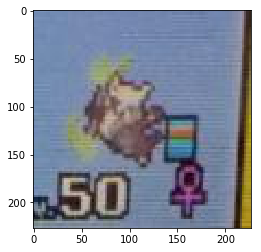

In [89]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(_images[8])

In [90]:
# 正規化
images = np.array(_images, dtype=np.float32) / 255.0
labels = np.array(_labels, dtype=np.int32)

In [91]:
# mean_img = np.mean(images, axis=0)
# plt.imshow(mean_img)

In [92]:
# for i in range(len(images)):
#     images[i] = images[i] - mean_img

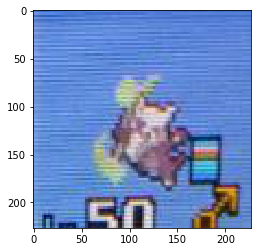

In [93]:
plt.imshow(images[0])

## chainerで扱えるようにRGBの層を手前に持ってくる

In [94]:
images = images.transpose(0,3,1,2)

In [95]:
images[0].shape
labels.shape

(304,)

## 画像と正解ラベルのペアを作成する

In [96]:
x_train = chainer.datasets.TupleDataset(images, labels)

In [97]:
x_train[0]

(array([[[ 0.33725491,  0.33725491,  0.31764707, ...,  0.26666668,
           0.26274511,  0.26274511],
         [ 0.33725491,  0.33725491,  0.31764707, ...,  0.26666668,
           0.26274511,  0.26274511],
         [ 0.44313726,  0.44313726,  0.41568628, ...,  0.32156864,
           0.31764707,  0.31764707],
         ..., 
         [ 0.38039216,  0.38039216,  0.41176471, ...,  0.40784314,
           0.41176471,  0.41176471],
         [ 0.50588238,  0.50588238,  0.52941179, ...,  0.40000001,
           0.40784314,  0.40784314],
         [ 0.50588238,  0.50588238,  0.52941179, ...,  0.40000001,
           0.40784314,  0.40784314]],
 
        [[ 0.49803922,  0.49803922,  0.47450981, ...,  0.43921569,
           0.43529412,  0.43529412],
         [ 0.49803922,  0.49803922,  0.47450981, ...,  0.43921569,
           0.43529412,  0.43529412],
         [ 0.59215689,  0.59215689,  0.57647061, ...,  0.49411765,
           0.49019608,  0.49019608],
         ..., 
         [ 0.53333336,  0.53333

## 入力に渡すiteratorの作成

In [98]:
train_iter = iterators.SerialIterator(x_train, batch_size=100, shuffle=True)

## modelの作成

In [99]:
model = AlexNet()

## 最適化手法の選択

In [120]:
optimizer = optimizers.Adam()
optimizer.setup(model)

## undaterとtrainerの作成
device=0で処理が0番GPUに投げられるはず  
訓練結果はresultディレクトリに作成されるはず

In [121]:
updater = training.StandardUpdater(train_iter, optimizer, device=0)

In [122]:
trainer = training.Trainer(updater, (200, 'epoch'), out='result')

## Logの出力設定

In [117]:
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch', 'main/accuracy', 'main/loss']))
trainer.extend(extensions.ProgressBar())

trainer.extend(extensions.ExponentialShift('lr', 0.97))

In [118]:
trainer.run()

AttributeError: can't set attribute

In [70]:
from chainer import cuda

true_label 4
network's output
0.300249
0.400932
0.122491
0.128432
0.047895
1


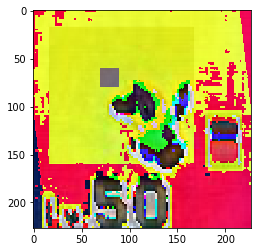

In [78]:
img, label = x_train[300]
plt.imshow(img.transpose(1,2,0))
model.train=False
cuda.check_cuda_available()
cuda.get_device(0).use()
xp = cuda.cupy
# img = Image.open("./dataset/445-0.jpg").resize((227,227))
# img = np.array(img, dtype=np.float32) / 255
# img = img.transpose(2,0,1)
print("true_label",label)
print("network's output")
out = model(xp.asarray(img[None,:]))
print(out[0,0])
print(out[0,1])
print(out[0,2])
print(out[0,3])
print(out[0,4])

print(np.argmax(out))